In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller #for adf test
import scipy.stats as stats #for jb test
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from dataclasses import dataclass
from typing import List, Iterator, Dict, Tuple
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight

In [111]:
#import and display corn price data
daily_corn = pd.read_csv("corn_prices_daily.csv", dtype={"date": "string"})
daily_corn["date"] = pd.to_datetime(daily_corn["date"].str.strip(), format="%d/%m/%Y")
daily_corn = daily_corn.sort_values("date").reset_index(drop=True)
daily_corn.head()

,date,Last Price
0,1992-01-02,2.41
1,1992-01-03,2.39
2,1992-01-06,2.40
3,1992-01-07,2.40
4,1992-01-08,2.43


In [112]:
#import and display drought probability data
weekly_probs_h1 = pd.read_csv("h1_probs.csv", parse_dates=["date"])
weekly_probs_h1.head()

,date,p_state0_h1,p_state1_h1,p_state2_h1
0,1992-01-05,0.943529,0.055841,0.000629
1,1992-01-12,0.949237,0.050318,0.000445
2,1992-01-19,0.922941,0.075764,0.001295
3,1992-01-26,0.781818,0.212314,0.005868
4,1992-02-02,0.400583,0.581123,0.018294


In [113]:
# =========================
# merge the two datasets based on dates from weekly drought probabilities, then check for missing
# values - if there is a missing values fill by last available date - the furthest back you can go is
# 4 days (data on Sunday never available so last date allowed is Wed), shwo in a table how many times you need fallback
# =========================
# weekly_probs_h1 : DataFrame with Sunday 'date' + state prob columns (e.g., p_state0_h1, ...)
# daily_corn      : DataFrame with business-day 'date' + price columns (e.g., 'close', ...)
# If your dates are index instead of a column, the helper below lifts them.

def ensure_date_col(df: pd.DataFrame, date_col: str = "date") -> pd.DataFrame:
    out = df.copy()
    if date_col not in out.columns and isinstance(out.index, pd.DatetimeIndex):
        out = out.reset_index().rename(columns={"index": date_col})
    out[date_col] = pd.to_datetime(out[date_col])
    return out

# Normalize inputs
wp = ensure_date_col(weekly_probs_h1, "date").sort_values("date")
dc = ensure_date_col(daily_corn, "date").sort_values("date")

# (Optional) deduplicate daily prices per date, keep the last record if duplicates exist
dc = dc.drop_duplicates(subset=["date"], keep="last")

# Identify price columns (everything except 'date')
price_cols = [c for c in dc.columns if c != "date"]
if not price_cols:
    raise ValueError("No price columns found in daily_corn (expected at least one non-'date' column).")

use_dc = dc[["date"] + price_cols].copy()

# =================================
# Dataset A: exact Friday (Sun-2d)
# =================================
A = wp.copy()
A["date_for_price2"] = A["date"] - pd.Timedelta(days=2)

use_dc2 = use_dc.rename(columns={"date": "date_for_price2"})
A = (
    pd.merge(A, use_dc2, on="date_for_price2", how="left")
      .sort_values("date")
      .reset_index(drop=True)
)

# IMPORTANT: record whether Friday had price BEFORE any fallback fill
A["fri_has_price"] = A[price_cols].notna().any(axis=1)

# Save A without helper cols (keep Sunday date + probs + prices)
A_out = A.drop(columns=["date_for_price2"])
A_out.to_csv("joined_sunday_minus2_exact.csv", index=False)

# ======================================================
# Dataset B: Friday or last available (≤ Sunday - 4 days)
# ======================================================
# A, price_cols, wp, use_dc already defined above

# As-of join: last available price at/before Sunday, but only within 4 days
use_dc_asof = use_dc.copy()
use_dc_asof["price_date"] = use_dc_asof["date"]

asof_tmp = pd.merge_asof(
    wp[["date"]].sort_values("date"),
    use_dc_asof.sort_values("date"),
    on="date",
    direction="backward",
    tolerance=pd.Timedelta(days=4)   # <- cap fallback to Sunday-4
)

# Attach as-of values & fill ONLY where Friday was missing
asof_fill = asof_tmp.rename(columns={c: f"{c}__asof" for c in price_cols})
asof_fill = asof_fill.rename(columns={"price_date": "price_date__asof"})

B = pd.merge(A, asof_fill[["date", "price_date__asof"] + [f"{c}__asof" for c in price_cols]],
             on="date", how="left")

for c in price_cols:
    # If Friday had price, keep it. Else use as-of (NaN if >4 days away)
    B[c] = B[c].where(B["fri_has_price"], B[f"{c}__asof"])

# Which date did we actually use?
B["price_date_used"] = pd.NaT
B.loc[B["fri_has_price"],  "price_date_used"] = B.loc[B["fri_has_price"],  "date_for_price2"]   # Fri (Sun-2)
B.loc[~B["fri_has_price"], "price_date_used"] = B.loc[~B["fri_has_price"], "price_date__asof"]  # as-of (≤4 days)

# Fallback days (NaN if no price within ≤4 days)
B["fallback_days"] = (B["date"] - B["price_date_used"]).dt.days

# Clean & save
drop_cols = [f"{c}__asof" for c in price_cols] + ["price_date__asof", "date_for_price2", "fri_has_price"]
B_out = (B.drop(columns=drop_cols)
           .sort_values("date")
           .reset_index(drop=True))
B_out.to_csv("joined_sunday_minus2_or_last_max4d.csv", index=False)

# Quick sanity: any rows beyond 4 days? (should be none due to tolerance)
print("Rows with fallback_days > 4:", int((B_out["fallback_days"] > 4).sum()))
print("Saved:", "joined_sunday_minus2_or_last_max4d.csv")

# ==========================
# NaN summary & comparisons
# ==========================
def nan_summary(df: pd.DataFrame, cols: list[str] | None = None) -> pd.DataFrame:
    if cols is None:
        cols = df.columns.tolist()
    nn = df[cols].isna().sum()
    pp = (df[cols].isna().mean() * 100).round(2)
    return pd.DataFrame({"n_nan": nn, "pct_nan": pp}).sort_values("n_nan", ascending=False)

print("NaN summary (ALL columns) — A (exact Fri):")
print(nan_summary(A_out), end="\n\n")

print("NaN summary (ALL columns) — B (fallback):")
print(nan_summary(B_out), end="\n\n")

# ======================
# fallback analysis table
# ======================
def fallback_counts_table(df: pd.DataFrame, col: str = "fallback_days",
                          values=(2, 3, 4)) -> pd.DataFrame:
    s = pd.to_numeric(df[col], errors="coerce")  # ensure numeric
    total_non_na = s.notna().sum()
    counts = (s[s.isin(values)]
              .value_counts()
              .reindex(values, fill_value=0)
              .rename("count"))
    out = counts.to_frame()
    out["pct"] = (out["count"] / total_non_na * 100).round(2)
    return out

# If your fallback dataset is B_out:
table = fallback_counts_table(B_out, "fallback_days", values=(2, 3, 4))
print(table)

Rows with fallback_days > 4: 0
Saved: joined_sunday_minus2_or_last_max4d.csv
NaN summary (ALL columns) — A (exact Fri):
               n_nan  pct_nan
Last Price        84     4.79
date               0     0.00
p_state0_h1        0     0.00
p_state1_h1        0     0.00
p_state2_h1        0     0.00
fri_has_price      0     0.00

NaN summary (ALL columns) — B (fallback):
                 n_nan  pct_nan
fallback_days        2     0.11
price_date_used      2     0.11
Last Price           2     0.11
p_state1_h1          0     0.00
p_state0_h1          0     0.00
date                 0     0.00
p_state2_h1          0     0.00

               count    pct
fallback_days              
2               1668  95.31
3                 62   3.54
4                 20   1.14


In [114]:
## check how long the series is - the end LSTM series should be 2 rows shorter to account for returns (current and future)
len(B)

1752

In [115]:
#get only data necessary for the modelling
# features
price_col = "Last Price"
B["ret_1"] = B[price_col].pct_change()   # past return t-1 -> t
# you can add more lags if you want:
# for k in [2,4,8]: df[f"ret_{k}"] = df[price_col].pct_change(k)
cols_to_keep = ['date', 'Last Price', 'ret_1'] + [c for c in B.columns if c.startswith("p_state") and c.endswith("_h1")]
data = B[cols_to_keep].copy()
print(data)
# make sure 'date' column is datetime
data['date'] = pd.to_datetime(data['date'])
# set as index
data = data.set_index('date').sort_index()

           date  Last Price     ret_1  p_state0_h1  p_state1_h1  p_state2_h1
0    1992-01-05        2.39       NaN     0.943529     0.055841     0.000629
1    1992-01-12        2.43  0.016736     0.949237     0.050318     0.000445
2    1992-01-19        2.48  0.020576     0.922941     0.075764     0.001295
3    1992-01-26        2.55  0.028226     0.781818     0.212314     0.005868
4    1992-02-02        2.57  0.007843     0.400583     0.581123     0.018294
...         ...         ...       ...          ...          ...          ...
1747 2025-06-29        4.00 -0.014778     0.938669     0.060752     0.000579
1748 2025-07-06        4.10  0.025000     0.955329     0.044461     0.000210
1749 2025-07-13        3.87 -0.056098     0.933028     0.066269     0.000704
1750 2025-07-20        3.95  0.020672     0.849863     0.147592     0.002545
1751 2025-07-27        3.87 -0.020253     0.682045     0.311690     0.006265

[1752 rows x 6 columns]


/tmp/ipython-input-2366972377.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  B["ret_1"] = B[price_col].pct_change()   # past return t-1 -> t


Prices change a lot so when fitting the minmax scalar for in teh cross validation expanding windows I dont think fitting it on just the first training sample will work. Thus I shall fit it each time for each expanding CV window - not fully comparable across the models but still realistic. One I'vee tuned the parameters I will fit a final scaler on the entire trainval period that will then also be used on the test set.


In [116]:
#Splitting the data into training, validation and test AND scaling the price data - no transf for the probabilities

@dataclass
class CVConfig:
    val_span: int        # e.g., 26 (weeks)
    step: int            # e.g., 4
    min_train_span: int  # e.g., 104

def make_static_splits(df: pd.DataFrame, test_start: str|pd.Timestamp):
    mask_test = df.index >= pd.to_datetime(test_start)
    return df.loc[~mask_test].copy(), df.loc[mask_test].copy()

def expanding_cv_folds(trainval_df: pd.DataFrame, price_col: str, cfg: CVConfig
) -> Iterator[Dict]:
    n = len(trainval_df); idx = np.arange(n)
    train_end = cfg.min_train_span
    while True:
        val_end = train_end + cfg.val_span
        if val_end > n: break
        train_mask = idx < train_end
        val_mask   = (idx >= train_end) & (idx < val_end)

        # Fit scaler ONLY on price from the current training slice
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(trainval_df.loc[train_mask, [price_col]].values)

        df_tr = trainval_df.loc[train_mask].copy()
        df_va = trainval_df.loc[val_mask].copy()

        # Transform price; leave probability columns AS-IS
        df_tr[price_col] = scaler.transform(df_tr[[price_col]])
        df_va[price_col] = scaler.transform(df_va[[price_col]])

        yield dict(
            train_mask=train_mask, val_mask=val_mask,
            df_train_scaled=df_tr, df_val_scaled=df_va,
            scaler=scaler,
            train_start=df_tr.index.min(), train_end=df_tr.index.max(),
            val_start=df_va.index.min(),   val_end=df_va.index.max()
        )
        train_end += cfg.step

def fit_final_scaler_and_transform(trainval_df: pd.DataFrame, price_col: str):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(trainval_df[[price_col]].values)     # fit on ALL train+val price
    out = trainval_df.copy()
    out[price_col] = scaler.transform(out[[price_col]])
    return out, scaler

def transform_test_with_scaler(test_df: pd.DataFrame, price_col: str, scaler: MinMaxScaler):
    out = test_df.copy()
    out[price_col] = scaler.transform(out[[price_col]])
    return out


In [117]:
#adf test for stationarity
result_adf = adfuller(daily_corn['Last Price'])
print('ADF Statistic:', result_adf[0])
print('p-value:', result_adf[1])

#jb test for normality
result_jb = stats.jarque_bera(daily_corn['Last Price'])
print('JB Statistic:', result_jb[0])
print('p-value:', result_jb[1])

ADF Statistic: -2.3639412575524474
p-value: 0.1521733616090581
JB Statistic: 1389.306994878197
p-value: 2.0692798436007628e-302


The use of LSTM (or in general ML models) makes sense because data is not stationary and not normally distributed.

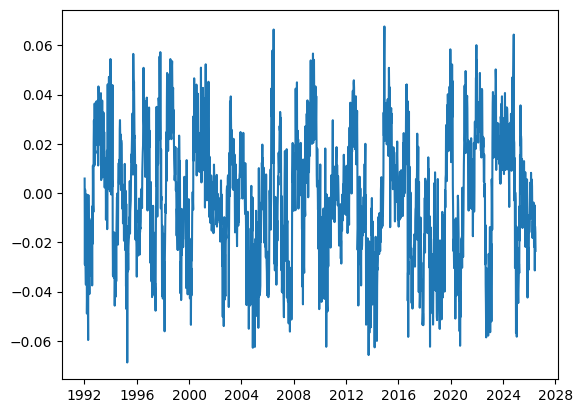

In [118]:
plt.plot(df["ret_1"])


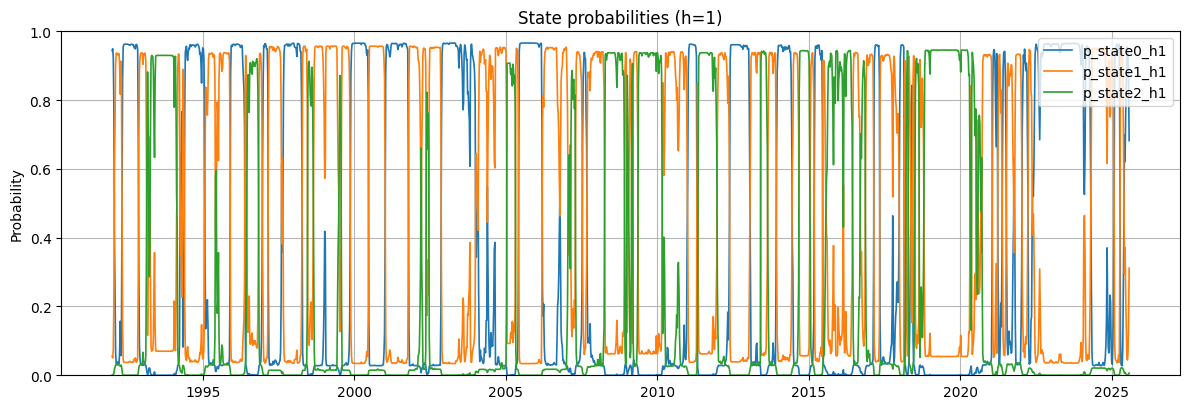

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_state_probs(df, horizon=1, date_col='date'):
    d = df.copy()
    d.columns = d.columns.astype(str).str.strip()

    # Make sure index is datetime
    if date_col in d.columns:
        d[date_col] = pd.to_datetime(d[date_col])
        d = d.sort_values(date_col).set_index(date_col)
    elif not isinstance(d.index, pd.DatetimeIndex):
        d.index = pd.to_datetime(d.index, errors='raise')
        d = d.sort_index()

    cols = [f"p_state{s}_h{horizon}" for s in range(3)]
    missing = [c for c in cols if c not in d.columns]
    if missing:
        raise KeyError(f"Missing columns: {missing}")

    fig, ax = plt.subplots(figsize=(12, 4.2))
    # Explicit, distinct colors as requested
    color_map = {
        cols[0]: 'tab:blue',
        cols[1]: 'tab:orange',
        cols[2]: 'tab:green'
    }

    for c in cols:
        ax.plot(d.index, d[c].values, label=c, linewidth=1.2, color=color_map[c])

    ax.set_ylim(0, 1)
    ax.set_ylabel("Probability")
    ax.set_title(f"State probabilities (h={horizon})")
    ax.grid(True, alpha=0.9)
    ax.legend(loc="upper right", ncol=1, frameon=True)

    # Nice yearly ticks
    ax.xaxis.set_major_locator(mdates.YearLocator(base=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.tight_layout()
    plt.show()

# Usage:
plot_state_probs(data, horizon=1)   # for p_state*_h1
# plot_state_probs(data, horizon=4)   # for p_state*_h4 if present


# Creating target price states for Y
For the first model version I am implementing a classification model with price predictions: 1)up 2)down 3)neutral.

I can construct a pricing strategy for the farmers under these predictions, where they sell more today if the price is said to drop next week, sell less today and more next week if the price is set to increase and sell the same amount today as next week if price is set to remian neutral.

I apply neutral with some bandwith.

In [120]:
def make_price_direction_labels(df, price_col="Last Price", horizon=1, neutral_band=0.005):
    out = df.copy()
    future = out[price_col].shift(-horizon)              # P_{t+h}
    ret_fwd = (future / out[price_col]) - 1.0            # (P_{t+h}/P_t) - 1
    target = np.zeros(len(out), dtype=int)               # 0 = neutral
    target[ret_fwd >  neutral_band] = 1                  # up
    target[ret_fwd < -neutral_band] = -1                 # down
    out["target"] = target
    # drop last horizon rows where future is unknown
    return out.iloc[:-horizon].copy()

# this saves the retrun t to t+1 in the row t - but this works because this data point "target" is only used for
#confirmation of model prediction power

#currently I use Last price data for this calc and not returns to stay with original data as much as possible - and also
# in order to not confuse the two returns - the ret_1 is t-1 to t return while the classes here are determined on t to t+1 retruns


In [121]:
df_LSTM = make_price_direction_labels(data, price_col="Last Price", horizon=1, neutral_band=0.005)
#df_LSTM = df_LSTM.dropna(subset=["ret_1"])
len(df_LSTM) #should be 2 shorter than the original merged dataset


1751

In [122]:
print(df_LSTM)

            Last Price     ret_1  p_state0_h1  p_state1_h1  p_state2_h1  \
date                                                                      
1992-01-05        2.39       NaN     0.943529     0.055841     0.000629   
1992-01-12        2.43  0.016736     0.949237     0.050318     0.000445   
1992-01-19        2.48  0.020576     0.922941     0.075764     0.001295   
1992-01-26        2.55  0.028226     0.781818     0.212314     0.005868   
1992-02-02        2.57  0.007843     0.400583     0.581123     0.018294   
...                ...       ...          ...          ...          ...   
2025-06-22        4.06 -0.044706     0.842409     0.154882     0.002709   
2025-06-29        4.00 -0.014778     0.938669     0.060752     0.000579   
2025-07-06        4.10  0.025000     0.955329     0.044461     0.000210   
2025-07-13        3.87 -0.056098     0.933028     0.066269     0.000704   
2025-07-20        3.95  0.020672     0.849863     0.147592     0.002545   

            target  
dat

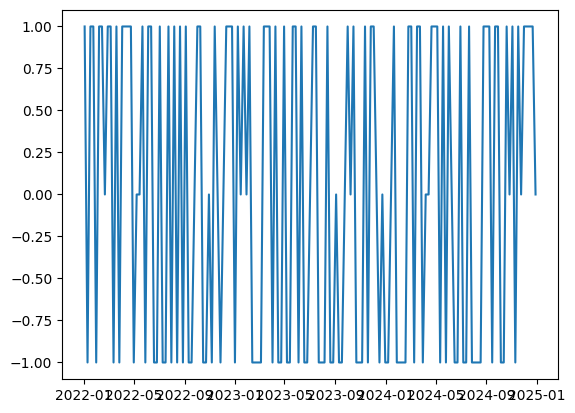

In [123]:
df_LSTM = df_LSTM.sort_index().copy()
df_short = df_LSTM.loc[(df_LSTM.index < pd.Timestamp("2025-01-01")) & (df_LSTM.index > pd.Timestamp("2022-01-01"))].copy()
plt.plot(df_short['target'])

In [124]:
#split training-test set
def make_static_splits(df: pd.DataFrame, test_start: str|pd.Timestamp):
    mask_test = df.index >= pd.to_datetime(test_start) #creates a boolean that shows where the test set is
    return df.loc[~mask_test].copy(), df.loc[mask_test].copy()
trainval_df, test_df = make_static_splits(df_LSTM, test_start="2022-01-01") #more than 150 points of prediction in test set

In [125]:
#here I'm creating samples bundeled with the loockback to use in training and validating and testing the model

feature_cols = [#"p_state0_h1", "p_state1_h1","p_state2_h1",
                 "ret_1"]#, #"Last Price"]
def make_sequences(df, *, feature_cols, target_col="target", lookback=52):
    """
    Returns:
      X: (n_samples, lookback, n_features)
      y: (n_samples,)
    """
    X, y = [], []
    feature_cols = list(feature_cols)  # ensure list
    cols = feature_cols + [target_col]
    vals = df[cols].to_numpy()
    nfeat = len(feature_cols)
    for i in range(len(df) - lookback):
        X.append(vals[i:i+lookback, :nfeat])      # 2D: (lookback, n_features)
        y.append(vals[i+lookback-1, nfeat])       # scalar class index
    X = np.asarray(X)
    y = np.asarray(y)
    # sanity checks
    assert X.ndim == 3, f"X must be 3D, got {X.shape}"
    assert y.ndim == 1, f"y must be 1D, got {y.shape}"
    return X, y



In [126]:
def build_lstm_classifier(input_dim: int, units: int = 64, lookback: int = 52):
    inputs = keras.Input(shape=(lookback, input_dim))
    x = layers.LSTM(units, return_sequences=False)(inputs)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


In [127]:
lookback=52

In [128]:
#code to plot class count in CV code to check for class imbalance in training and val sets

def plot_class_counts(y_tr, y_va, enc, fold_info=""):
    # original labels: -1, 0, 1
    labels = [-1,0, 1]
    names = [str(l) for l in labels]

    # counts
    counts_tr = [np.sum(y_tr == l) for l in labels]
    counts_va = [np.sum(y_va == l) for l in labels]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(x - width/2, counts_tr, width, label="Train")
    ax.bar(x + width/2, counts_va, width, label="Val")
    ax.set_xticks(x)
    ax.set_xticklabels(names)
    ax.set_ylabel("Count")
    ax.set_title(f"Class counts per fold {fold_info}")
    ax.legend()
    plt.show()


In [129]:
#this si code to create generated data for testing of the model - not part of the actual model
# i just have this to check why model is not performing as it should

# ----------------------------
# 1) Balanced 3-class targets with segments
# ----------------------------
""" def _make_balanced_targets(n, classes=(-1, 0, 1), min_seg=6, max_seg=24, seed=42):
    """
    Build a 1D array of length n with equal counts for each class (±1 item if n%3!=0),
    arranged in contiguous segments so a sequence model can exploit temporal structure.
    """
    rng = np.random.default_rng(seed)
    K = len(classes)
    base = n // K
    remainder = n - base * K  # 0,1,2
    counts = {c: base for c in classes}
    # Distribute remainder to the first 'remainder' classes
    for c in classes[:remainder]:
        counts[c] += 1

    # For each class, split its total count into random segment lengths
    segs = []
    for c in classes:
        need = counts[c]
        lengths = []
        while need > 0:
            L = int(rng.integers(min_seg, max_seg + 1))
            L = min(L, need)
            lengths.append(L)
            need -= L
        # Slight shuffle of this class's segments to avoid a pattern
        rng.shuffle(lengths)
        segs.extend([(c, L) for L in lengths])

    # Shuffle all segments, then merge adjacent same-class segments
    rng.shuffle(segs)
    merged = []
    for c, L in segs:
        if merged and merged[-1][0] == c:
            merged[-1] = (c, merged[-1][1] + L)
        else:
            merged.append((c, L))

    # Concatenate to labels (should be exactly length n)
    y = np.concatenate([np.full(L, c, dtype=int) for c, L in merged])
    if len(y) != n:
        # If tiny mismatch due to rounding, trim or pad with zeros
        y = y[:n] if len(y) > n else np.concatenate([y, np.zeros(n - len(y), dtype=int)])
    return y

# ----------------------------
# 2) Feature generator tied to class
# ----------------------------
def _make_features_from_state(y, seed=42):
    """
    Build several features influenced by the latent class y_t in {-1,0,1}.
    - feat_ar: AR-ish signal driven by lagged class
    - feat_sin: class-specific phase on a sinusoid
    - feat_vol: noise scale depends on class
    - ret_1 + Last Price: price path with class-dependent drift/vol
    """
    rng = np.random.default_rng(seed)
    n = len(y)
    y_float = y.astype(float)

    # (a) AR-ish feature influenced by lagged state
    feat_ar = np.zeros(n)
    noise_ar = rng.normal(0, 0.25, size=n)
    for t in range(1, n):
        lag_state = y_float[t - 2] if t - 2 >= 0 else 0.0
        feat_ar[t] = 0.75 * feat_ar[t - 1] + 0.35 * lag_state + noise_ar[t]

    # (b) Sinusoid with class-specific phase shifts
    tgrid = np.arange(n)
    period = 32  # change as you like
    phases = { -1: 0.0, 0: 2*np.pi/3, 1: 4*np.pi/3 }
    feat_sin = np.sin(2*np.pi * tgrid / period + np.vectorize(phases.get)(y)) + rng.normal(0, 0.15, size=n)

    # (c) Volatility-coded noise feature
    vol_map = { -1: 0.5, 0: 0.2, 1: 0.35 }  # different std by class
    feat_vol = rng.normal(0, np.vectorize(vol_map.get)(y))

    # (d) Price path: class-dependent drift + AR signal influence + class vol
    drift_map = { -1: -0.0025, 0: 0.0, 1: 0.0025 }         # per-step drift (e.g., weekly)
    sigma_map = { -1: 0.015, 0: 0.007, 1: 0.011 }          # per-step noise
    ret_1 = (np.vectorize(drift_map.get)(y)
             + 0.02 * feat_ar
             + rng.normal(0, np.vectorize(sigma_map.get)(y)))
    # Build price (log returns for stability)
    price = 100.0 * np.exp(np.cumsum(ret_1))
    return feat_ar, feat_sin, feat_vol, ret_1, price

# ----------------------------
# 3) Public function: make dataframe
# ----------------------------
def make_synthetic_lstm_dataset(n=1800, freq="W-SUN", start="1990-01-07", seed=42):
    """
   # Returns:
    #  df: DataFrame indexed by date with columns:
          ['Last Price','ret_1','feat_ar','feat_sin','feat_vol','target','target_012']
     # feats: list of feature column names (for modeling)
    """
    y = _make_balanced_targets(n, seed=seed)
    feat_ar, feat_sin, feat_vol, ret_1, price = _make_features_from_state(y, seed=seed)

    dates = pd.date_range(start=start, periods=n, freq=freq)
    df = pd.DataFrame({
        "Last Price": price,
        "ret_1": ret_1,
        "feat_ar": feat_ar,
        "feat_sin": feat_sin,
        "feat_vol": feat_vol,
        "target": y
    }, index=dates)
    # Optional: map {-1,0,1} -> {0,1,2} for Keras sparse_categorical_crossentropy
    mapper = {-1:0, 0:1, 1:2}
    df["target_012"] = df["target"].map(mapper).astype(int)

    feats = ["ret_1", "feat_ar", "feat_sin", "feat_vol"]
    return df, feats

# ----------------------------
# 4) Turn into LSTM sequences (X,y)
# ----------------------------
def make_sequences(df, feature_cols, target_col="target_012", lookback=32, horizon=0):
    """
    #Build supervised samples for LSTM:
     # X[i] = rows [t-lookback+1 .. t] of feature_cols
      #y[i] = target at t + horizon
    #Shapes:
     # X: (n_samples, lookback, n_features)
      #y: (n_samples,)
    """
    values = df[feature_cols].values
    y_all = df[target_col].values
    n, n_feat = values.shape

    # valid end index for input window is t, and we need y at t+h
    T = n - lookback - horizon
    X = np.empty((T, lookback, n_feat), dtype=np.float32)
    y = np.empty((T,), dtype=np.int64)

    for i in range(T):
        t = i + lookback - 1
        X[i] = values[i:i+lookback]
        y[i] = y_all[t + horizon]
    return X, y

# ----------------------------
# 5) Example usage
# ----------------------------
if __name__ == "__main__":
    df, feats = make_synthetic_lstm_dataset(n=1800, freq="W-SUN", start="1992-01-05", seed=7)
    print(df.head(), "\n\nClass counts:\n", df["target"].value_counts().sort_index())

    # Build sequences
    X, y = make_sequences(df, feature_cols=feats, target_col="target_012", lookback=26, horizon=1)
    print("X shape:", X.shape, "y shape:", y.shape)

    # Simple time split (60/20/20) WITHOUT shuffling
    n = X.shape[0]
    n_tr = int(0.6 * n); n_va = int(0.2 * n)
    X_tr, y_tr = X[:n_tr], y[:n_tr]
    X_va, y_va = X[n_tr:n_tr+n_va], y[n_tr:n_tr+n_va]
    X_te, y_te = X[n_tr+n_va:], y[n_tr+n_va:]

    # Minimal Keras model (uncomment to try)
    # from tensorflow import keras
    # model = keras.Sequential([
    #     keras.layers.Input(shape=(X_tr.shape[1], X_tr.shape[2])),
    #     keras.layers.LSTM(64),
    #     keras.layers.Dropout(0.2),
    #     keras.layers.Dense(3, activation="softmax")
    # ])
    # model.compile(optimizer=keras.optimizers.Adam(1e-3),
    #               loss="sparse_categorical_crossentropy",
    #               metrics=["accuracy"])
    # model.fit(X_tr, y_tr, validation_data=(X_va, y_va),
    #           epochs=25, batch_size=64, shuffle=False, verbose=1)
"""

IndentationError: unexpected indent (ipython-input-2497458872.py, line 9)

In [ ]:
"""df
trainval_df, test_df = make_static_splits(df, test_start="2022-01-01")"""

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


X_tr (468, 52, 1) X_va (148, 52, 1)
y_tr (468,) y_va (148,)


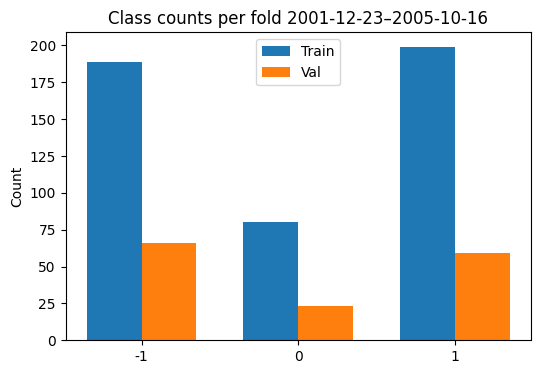

2001-12-23–2005-10-16 | val_acc=0.446
X_tr (520, 52, 1) X_va (148, 52, 1)
y_tr (520,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


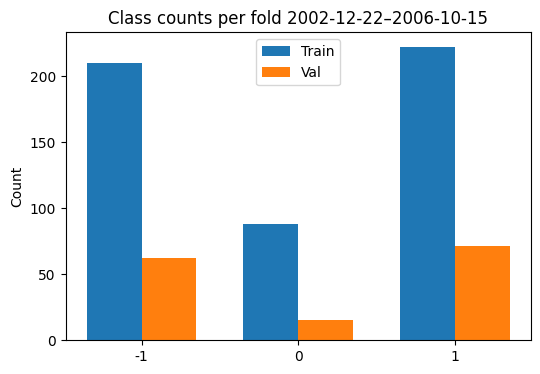

2002-12-22–2006-10-15 | val_acc=0.419
X_tr (572, 52, 1) X_va (148, 52, 1)
y_tr (572,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


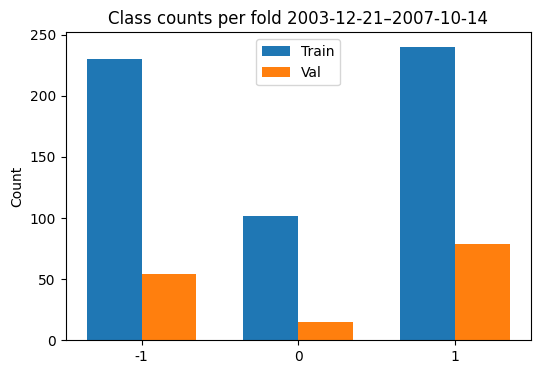

2003-12-21–2007-10-14 | val_acc=0.365
X_tr (624, 52, 1) X_va (148, 52, 1)
y_tr (624,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


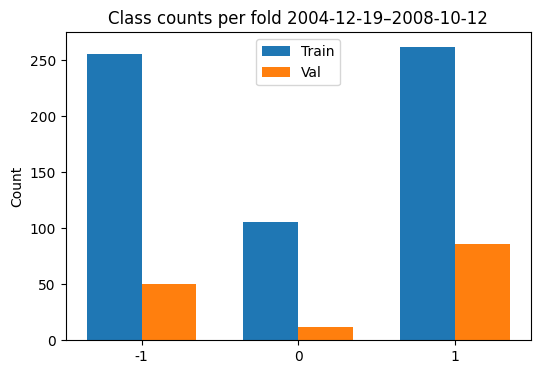

2004-12-19–2008-10-12 | val_acc=0.338
X_tr (676, 52, 1) X_va (148, 52, 1)
y_tr (676,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


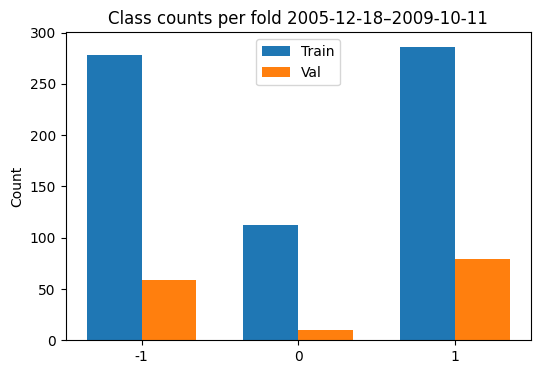

2005-12-18–2009-10-11 | val_acc=0.399
X_tr (728, 52, 1) X_va (148, 52, 1)
y_tr (728,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


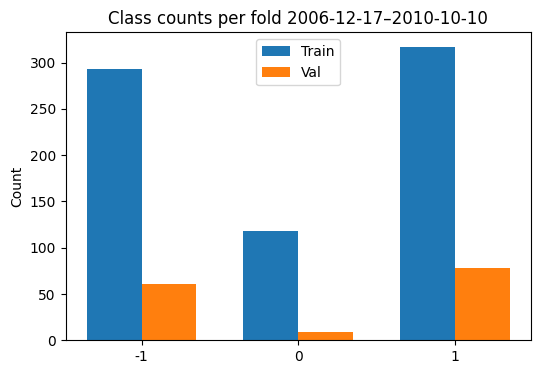

2006-12-17–2010-10-10 | val_acc=0.412
X_tr (780, 52, 1) X_va (148, 52, 1)
y_tr (780,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


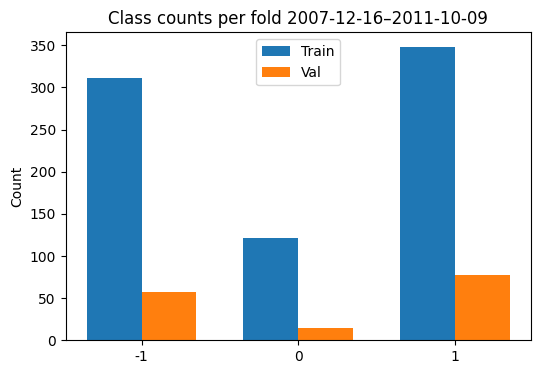

2007-12-16–2011-10-09 | val_acc=0.385
X_tr (832, 52, 1) X_va (148, 52, 1)
y_tr (832,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


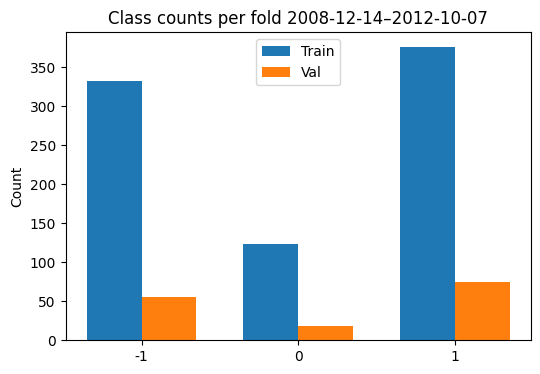

2008-12-14–2012-10-07 | val_acc=0.372
X_tr (884, 52, 1) X_va (148, 52, 1)
y_tr (884,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


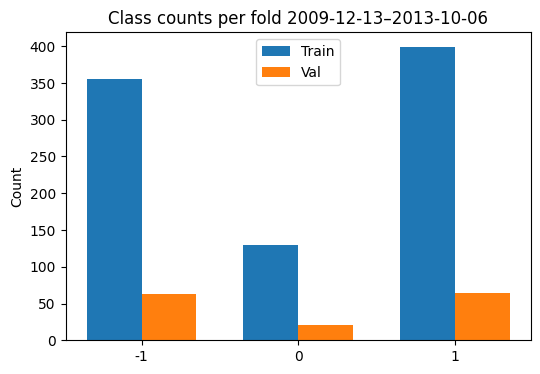

2009-12-13–2013-10-06 | val_acc=0.426
X_tr (936, 52, 1) X_va (148, 52, 1)
y_tr (936,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


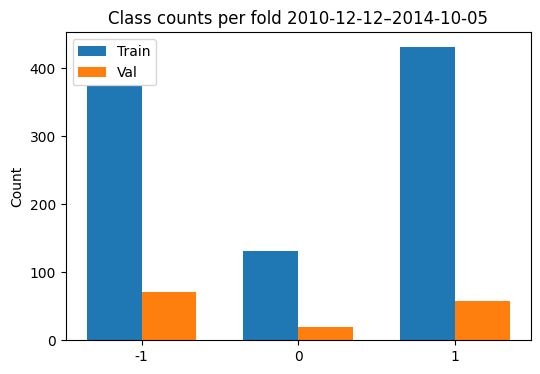

2010-12-12–2014-10-05 | val_acc=0.480
X_tr (988, 52, 1) X_va (148, 52, 1)
y_tr (988,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


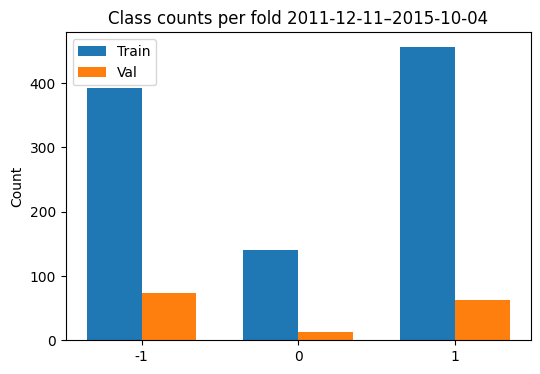

2011-12-11–2015-10-04 | val_acc=0.493
X_tr (1040, 52, 1) X_va (148, 52, 1)
y_tr (1040,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


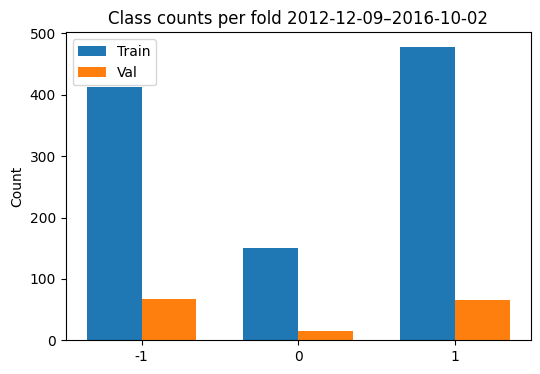

2012-12-09–2016-10-02 | val_acc=0.453
X_tr (1092, 52, 1) X_va (148, 52, 1)
y_tr (1092,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


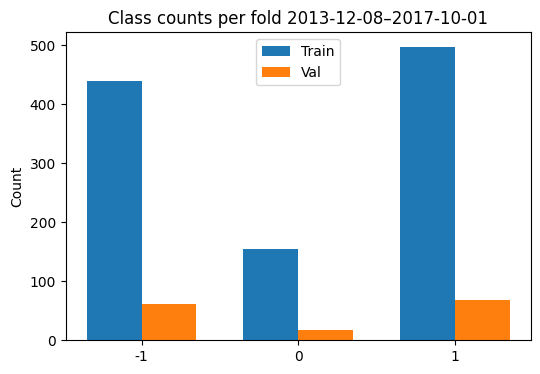

2013-12-08–2017-10-01 | val_acc=0.419
X_tr (1144, 52, 1) X_va (148, 52, 1)
y_tr (1144,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


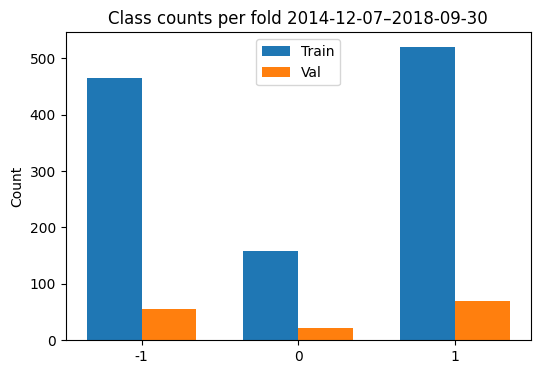

2014-12-07–2018-09-30 | val_acc=0.378
X_tr (1196, 52, 1) X_va (148, 52, 1)
y_tr (1196,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


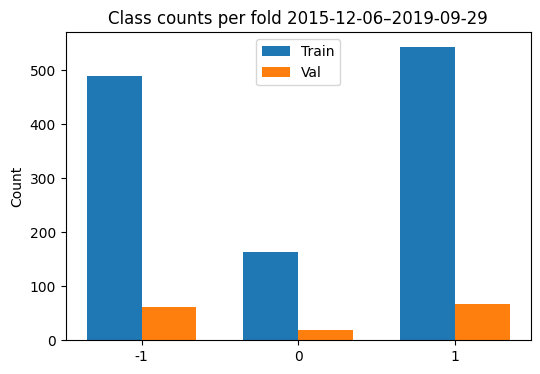

2015-12-06–2019-09-29 | val_acc=0.412
X_tr (1248, 52, 1) X_va (148, 52, 1)
y_tr (1248,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


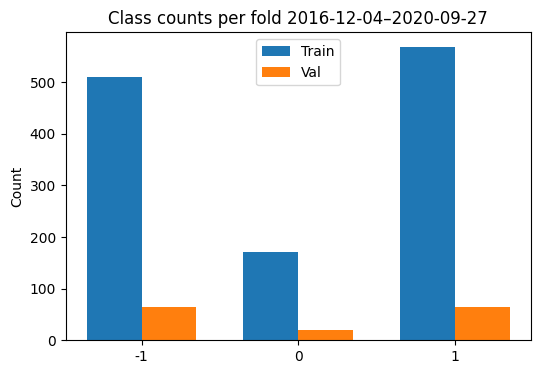

2016-12-04–2020-09-27 | val_acc=0.432
X_tr (1300, 52, 1) X_va (148, 52, 1)
y_tr (1300,) y_va (148,)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


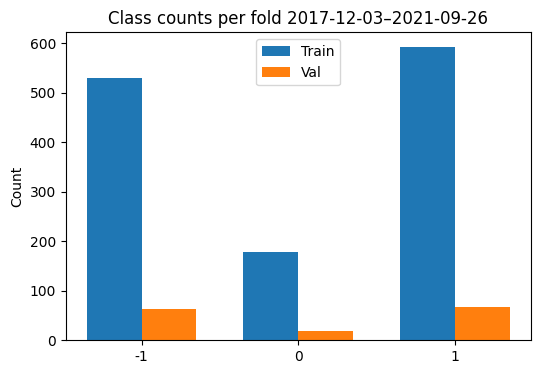

2017-12-03–2021-09-26 | val_acc=0.426
CV mean acc: 0.4149443577317631


In [130]:
cfg = CVConfig(val_span=200, step=52, min_train_span=520)

enc = LabelEncoder().fit([-1,0, 1])  # fixed mapping for all folds

val_scores = []
for fold in expanding_cv_folds(trainval_df, price_col=price_col, cfg=cfg):
    df_tr, df_va = fold["df_train_scaled"], fold["df_val_scaled"]

    # ---- Build LSTM-ready arrays with your make_sequences ----
    X_tr, y_tr = make_sequences(df_tr, feature_cols=feature_cols, target_col="target", lookback=lookback)
    X_va, y_va = make_sequences(df_va, feature_cols=feature_cols, target_col="target", lookback=lookback)
    print("X_tr", X_tr.shape, "X_va", X_va.shape)   # expect (*, lookback, 6)
    print("y_tr", y_tr.shape, "y_va", y_va.shape)   # expect (*,), (*,)

    # encode labels { -1,0,1 } -> { 0,1,2 } and one-hot for softmax
    y_tr_oh = to_categorical(enc.transform(y_tr), num_classes=3)
    y_va_oh = to_categorical(enc.transform(y_va), num_classes=3)

    # ---- Build & train the LSTM classifier ----
    model = build_lstm_classifier(input_dim=X_tr.shape[2], units=64)
    plot_class_counts(y_tr, y_va, enc, fold_info=f"{fold['val_start'].date()}–{fold['val_end'].date()}")
    model.fit(
    X_tr, y_tr_oh,
    validation_data=(X_va, y_va_oh),
    epochs=12, batch_size=32, verbose=0,
    shuffle=False,  # IMPORTANT for time series
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=3, restore_best_weights=True)
        ]
    )

    # ---- Evaluate on validation fold ----
    val_loss, val_acc = model.evaluate(X_va, y_va_oh, verbose=0)
    val_scores.append(val_acc)
    print(f"{fold['val_start'].date()}–{fold['val_end'].date()} | val_acc={val_acc:.3f}")

print("CV mean acc:", float(np.mean(val_scores)))


In [131]:
# Bridge builder: use last `lookback` TRAIN rows to seed first TEST windows
def make_sequences_bridge(df_hist, df_future, feature_cols, target_col, lookback):
    tr = df_hist.sort_index().dropna(subset=feature_cols + [target_col])
    fv = df_future.sort_index().dropna(subset=feature_cols + [target_col])
    if len(tr) < lookback:
        raise ValueError(f"Need at least {lookback} clean rows in df_hist; got {len(tr)}.")
    bridge = pd.concat([tr.tail(lookback), fv], axis=0)

    feat = bridge[feature_cols].to_numpy()
    X_list, y_list = [], []
    # fv index set for membership test
    fv_idx = set(fv.index)

    for i in range(lookback, len(bridge)):
        idx = bridge.index[i]
        if idx in fv_idx:  # ensure target comes from FUTURE block only
            X_list.append(feat[i - lookback:i, :])
            y_list.append(fv.loc[idx, target_col])

    X = np.asarray(X_list)
    y = np.asarray(y_list)
    return X, y

# tiny utility to compute class weights on a numeric y in {-1,0,1}
def compute_class_weight(y_numeric, enc):
    classes, counts = np.unique(y_numeric, return_counts=True)
    total = counts.sum()
    k = len(classes)
    # map original labels {-1,0,1} to {0,1,2}
    weights = {}
    for c, cnt in zip(classes, counts):
        weights[enc.transform([c])[0]] = total / (k * cnt)
    return weights

# =========================
# 1) Hyperparam grid to search in CV
#    (trim/extend as you like)
# =========================
param_grid = [
    {"units": 32},
    {"units": 64},
    {"units": 96},
]

# =========================
# 2) Cross-validate each config on TRAIN+VAL
# =========================
results = []  # will store dicts with {"params":..., "fold_metrics":[...], "mean_acc":...}

for params in param_grid:
    units = params["units"]
    print(f"\n=== CV for params: {params} ===")
    fold_accs = []

    for fold in expanding_cv_folds(trainval_df, price_col=price_col, cfg=cfg):
        df_tr, df_va = fold["df_train_scaled"], fold["df_val_scaled"]

        # Build sequences
        X_tr, y_tr = make_sequences(df_tr, feature_cols=feature_cols, target_col="target", lookback=lookback)
        X_va, y_va = make_sequences(df_va, feature_cols=feature_cols, target_col="target", lookback=lookback)

        # One-hot labels
        y_tr_oh = to_categorical(enc.transform(y_tr), num_classes=3)
        y_va_oh = to_categorical(enc.transform(y_va), num_classes=3)

        # Class weights (optional but helpful if imbalanced)
        cw = compute_class_weight(y_tr, enc)

        # Build & train
        model = build_lstm_classifier(input_dim=X_tr.shape[2], units=units, lookback=lookback)
        es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        hist = model.fit(
            X_tr, y_tr_oh,
            validation_data=(X_va, y_va_oh),
            epochs=40, batch_size=32,
            shuffle=False, verbose=0,
            class_weight=cw,
            callbacks=[es],
        )

        # Evaluate on validation
        _, val_acc = model.evaluate(X_va, y_va_oh, verbose=0)
        fold_accs.append(float(val_acc))
        print(f"{fold['val_start'].date()}–{fold['val_end'].date()} | val_acc={val_acc:.3f}")

    results.append({
        "params": params,
        "fold_metrics": fold_accs,
        "mean_acc": float(np.mean(fold_accs))
    })

# Pick best params by mean CV accuracy
results = sorted(results, key=lambda d: d["mean_acc"], reverse=True)
best = results[0]
print("\n=== BEST by CV ===")
print("params:", best["params"])
print("mean_acc:", best["mean_acc"])

best_units = best["params"]["units"]

# =========================
# 3) Retrain FINAL model on ALL TRAIN+VAL
#    Use a small time-aware tail as internal val for early stopping
# =========================
# Build sequences on full train+val
X_all, y_all = make_sequences(trainval_df, feature_cols=feature_cols, target_col="target", lookback=lookback)

# Split a tail slice for early stopping (time-aware: last 10% or fixed N)
tail_frac = 0.1
n = len(X_all)
n_tail = max( max(lookback, 128), int(n * tail_frac) )  # ensure decent tail size
n_tail = min(n_tail, n - 1)  # keep at least 1 sample for train

X_tr_full, y_tr_full = X_all[:-n_tail], y_all[:-n_tail]
X_va_tail, y_va_tail = X_all[-n_tail:], y_all[-n_tail:]

y_tr_full_oh = to_categorical(enc.transform(y_tr_full), num_classes=3)
y_va_tail_oh = to_categorical(enc.transform(y_va_tail), num_classes=3)

cw_final = compute_class_weight(y_tr_full, enc)

final_model = build_lstm_classifier(input_dim=X_all.shape[2], units=best_units, lookback=lookback)
es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
rlr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=4, factor=0.5, verbose=0)

final_model.fit(
    X_tr_full, y_tr_full_oh,
    validation_data=(X_va_tail, y_va_tail_oh),
    epochs=80, batch_size=32,
    shuffle=False, verbose=1,
    class_weight=cw_final,
    callbacks=[es, rlr],
)

# =========================
# 4) Test on held-out TEST set
#    (Build sequences with a BRIDGE from train+val tail)
# =========================
X_te, y_te = make_sequences_bridge(trainval_df, test_df, feature_cols=feature_cols, target_col="target", lookback=lookback)
y_te_oh = to_categorical(enc.transform(y_te), num_classes=3)

test_loss, test_acc = final_model.evaluate(X_te, y_te_oh, verbose=0)
print(f"\nFINAL TEST | loss={test_loss:.4f}, acc={test_acc:.4f}")

# Optional: detailed report
y_pred = final_model.predict(X_te, verbose=0).argmax(axis=1)
y_true = enc.transform(y_te)
from sklearn.metrics import classification_report, confusion_matrix
print("\nTEST classification report\n", classification_report(y_true, y_pred, target_names=["-1","0","1"], digits=3))
print("TEST confusion matrix\n", confusion_matrix(y_true, y_pred))



=== CV for params: {'units': 32} ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2001-12-23–2005-10-16 | val_acc=0.446


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2002-12-22–2006-10-15 | val_acc=0.419


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2003-12-21–2007-10-14 | val_acc=0.365


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2004-12-19–2008-10-12 | val_acc=0.338


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2005-12-18–2009-10-11 | val_acc=0.399


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2006-12-17–2010-10-10 | val_acc=0.412


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2007-12-16–2011-10-09 | val_acc=0.385


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2008-12-14–2012-10-07 | val_acc=0.372


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2009-12-13–2013-10-06 | val_acc=0.426


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2010-12-12–2014-10-05 | val_acc=0.480


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2011-12-11–2015-10-04 | val_acc=0.493


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2012-12-09–2016-10-02 | val_acc=0.453


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2013-12-08–2017-10-01 | val_acc=0.419


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2014-12-07–2018-09-30 | val_acc=0.378


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2015-12-06–2019-09-29 | val_acc=0.412


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2016-12-04–2020-09-27 | val_acc=0.432


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2017-12-03–2021-09-26 | val_acc=0.426

=== CV for params: {'units': 64} ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2001-12-23–2005-10-16 | val_acc=0.446


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2002-12-22–2006-10-15 | val_acc=0.419


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2003-12-21–2007-10-14 | val_acc=0.365


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2004-12-19–2008-10-12 | val_acc=0.338


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2005-12-18–2009-10-11 | val_acc=0.399


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2006-12-17–2010-10-10 | val_acc=0.412


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2007-12-16–2011-10-09 | val_acc=0.385


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2008-12-14–2012-10-07 | val_acc=0.372


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2009-12-13–2013-10-06 | val_acc=0.426


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2010-12-12–2014-10-05 | val_acc=0.480


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2011-12-11–2015-10-04 | val_acc=0.493


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2012-12-09–2016-10-02 | val_acc=0.453


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2013-12-08–2017-10-01 | val_acc=0.419


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2014-12-07–2018-09-30 | val_acc=0.378


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2015-12-06–2019-09-29 | val_acc=0.412


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2016-12-04–2020-09-27 | val_acc=0.432


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2017-12-03–2021-09-26 | val_acc=0.426

=== CV for params: {'units': 96} ===


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2001-12-23–2005-10-16 | val_acc=0.446


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2002-12-22–2006-10-15 | val_acc=0.419


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2003-12-21–2007-10-14 | val_acc=0.365


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2004-12-19–2008-10-12 | val_acc=0.338


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2005-12-18–2009-10-11 | val_acc=0.399


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2006-12-17–2010-10-10 | val_acc=0.412


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2007-12-16–2011-10-09 | val_acc=0.385


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2008-12-14–2012-10-07 | val_acc=0.372


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2009-12-13–2013-10-06 | val_acc=0.426


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2010-12-12–2014-10-05 | val_acc=0.480


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2011-12-11–2015-10-04 | val_acc=0.493


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2012-12-09–2016-10-02 | val_acc=0.453


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2013-12-08–2017-10-01 | val_acc=0.419


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2014-12-07–2018-09-30 | val_acc=0.378


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2015-12-06–2019-09-29 | val_acc=0.412


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2016-12-04–2020-09-27 | val_acc=0.432


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


2017-12-03–2021-09-26 | val_acc=0.426

=== BEST by CV ===
params: {'units': 32}
mean_acc: 0.4149443577317631
Epoch 1/80
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.3859 - loss: nan - val_accuracy: 0.4106 - val_loss: nan - learning_rate: 1.0000e-04
Epoch 2/80
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.3890 - loss: nan - val_accuracy: 0.4106 - val_loss: nan - learning_rate: 1.0000e-04
Epoch 3/80
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3890 - loss: nan - val_accuracy: 0.4106 - val_loss: nan - learning_rate: 1.0000e-04
Epoch 4/80
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3890 - loss: nan - val_accuracy: 0.4106 - val_loss: nan - learning_rate: 1.0000e-04
Epoch 5/80
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3890 - loss: nan - val_accuracy: 0.4106 - val_loss: nan - learning_rate: 5.0000e-05
Epoch 6/80
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3890 - loss: nan - val_accuracy: 0.4106 - val_loss: nan - learning_rate: 5.0000e-


TEST classification report
               precision    recall  f1-score   support

          -1      0.430     1.000     0.602        80
           0      0.000     0.000     0.000        26
           1      0.000     0.000     0.000        80

    accuracy                          0.430       186
   macro avg      0.143     0.333     0.201       186
weighted avg      0.185     0.430     0.259       186

TEST confusion matrix
 [[80  0  0]
 [26  0  0]
 [80  0  0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
